<a href="https://colab.research.google.com/github/Tropini-lab/Eric_plate_reader_analysis/blob/main/384_Well_Fits_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
from scipy.signal import medfilt
from scipy import stats
pd.set_option('display.max_columns', 15)
import seaborn as sns
from matplotlib.pyplot import cm
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
from bokeh.models import Panel, Tabs
from bokeh.models import Span

In [ ]:
def max_derivative(time,od,st_time,end_time):
  st_index = int(len(time)*st_time / time[len(time)-1])
  end_index = int(len(time)*end_time / time[len(time)-1])
  timestep = time[1]-time[0]
  a = 4
  dt = a*timestep
  od = medfilt(od,kernel_size= 3)
  max_first_der = np.max([(od[x+a] - od[x])/dt for x in range(st_index,end_index-4)])
  return max_first_der

In [ ]:
def dist_from_edge(well_name):
  y_dict = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8}

  # Getting x and y values from the well name string
  x = int(well_name[1:])
  y = y_dict.get(str(well_name[:1]))

  # Solving for the minimum distance to an edge
  min_dist = np.min([np.min([abs(x-1),abs(x-12)]), np.min([abs(y-1), abs(y-8)])])
  return min_dist


In [ ]:
#Uploading 96 well data: 
def well96data(g_filename,m_filename,t_low,t_high): 
  #t_low and t_high are the upper and lower bounds for which to search for max OD.
  upload_96_growth = files.upload()
  growth_96_df = pd.read_excel(io.BytesIO(upload_96_growth[g_filename]),skiprows=6)
  growth_96_df['Time'] = growth_96_df['Time'] * 24 ## converting time into hours
  vial_names = list(growth_96_df.columns.values)[1:]
  smooth_max_od = []
  dist_from_plate_edge = []
  max_rates = []
  for name in vial_names:
    growth_96_df[name] = growth_96_df[name] - growth_96_df[name].iloc[0] #zeroing data
    max_od = np.max(medfilt(growth_96_df.loc[(growth_96_df['Time'] < t_high) & (growth_96_df['Time'] > t_low)][name],3))
    smooth_max_od.append(max_od)
    dist_from_plate_edge.append(dist_from_edge(name))
    # max_rates.append(max_derivative(growth_96_df['Time'], growth_96_df[name], 3,10))
    

  upload_96_meta = files.upload()
  meta_96_df = pd.read_excel(io.BytesIO(upload_96_meta[m_filename]))
  meta_96_df.insert(7,"Smooth_Max_OD",smooth_max_od)
  meta_96_df.insert(8,"Dist_From_Edge", dist_from_plate_edge)
  # meta_96_df.insert(9,"Max_Rate", max_rates)
  return growth_96_df,meta_96_df


In [ ]:
## Generating a nice boxplot with individual points added: 
def grapher(df,feature,title):
  headers = df.columns.values.tolist()
  print("The headers are:", headers)
  fig,ax = plt.subplots()
  #iterating throught the boxplot colums: 
  all_vals =[]
  for i,col in enumerate(df.columns):
    vals_wt_nans = df[col].tolist()
    vals = [x for x in vals_wt_nans if np.isnan(x) == False]
    all_vals.append(vals)
  
  # Adjusting this to combine phage - vials
  new_all_vals = all_vals[:3]
  phage_neg = all_vals[3]
  phage_neg.extend(all_vals[4])
  phage_neg.extend(all_vals[5])
  new_all_vals.append(phage_neg)

  for i,set in enumerate(new_all_vals):
    i=i+1
    y= set
    x= np.random.normal(i,0.04,size= len(y))
    ax.scatter(x,y,alpha=0.8)
  

  # Making new headers for a presentation: 
  new_headers = ['Phage +, low osm', 'Phage +, high osm','Phage +, medium osm', 'Bacteria Control' ]
  c='white'
  plt.style.use('dark_background')
  ax.boxplot(new_all_vals, notch=None, patch_artist=False,boxprops=dict(color=c, alpha =1),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )#,showfliers = False)
  ax.set_xticklabels(new_headers, rotation = 0, fontsize = 'x-large')
  ax.set_ylabel(feature, fontsize = 'x-large')
  ax.set_xlabel('Evolution Condition', fontsize = 'x-large')
  ax.set_title('Max OD Comparison' + title, fontsize = 'x-large')


  plt.grid(False)
  # plt.ylim(.3,1.2)
  plt.show()

In [ ]:
# Getting the two dataframes for each trial of 96 well data:
psg1_growth_df, psg1_meta_df = well96data('96_low_osmo_psg_3_growth.xlsx','96_low_osmo_psg3_meta.xlsx',0,40)
# psg2_growth_df, psg2_meta_df = well96data('long_high_psg_lid.xlsx','wt_v13_meta.xlsx',0,45)
print(psg1_meta_df.head())

Saving 96_low_osmo_psg_3_growth.xlsx to 96_low_osmo_psg_3_growth.xlsx


Saving 96_low_osmo_psg3_meta.xlsx to 96_low_osmo_psg3_meta.xlsx
   Ecoli present Well Osmolality  Vial Phage  Wild type  Column Number  \
0              1             low           0          1              1   
1              1             low           0          0              2   
2              1             low           1          0              3   
3              1             low           1          0              4   
4              1             low           1          0              5   

  Vial Osmolaity Well_Label  Smooth_Max_OD  Dist_From_Edge  
0            low         A1          0.008               0  
1            low         A2          0.612               0  
2            low         A3          0.720               0  
3            low         A4          0.837               0  
4         medium         A5          0.751               0  


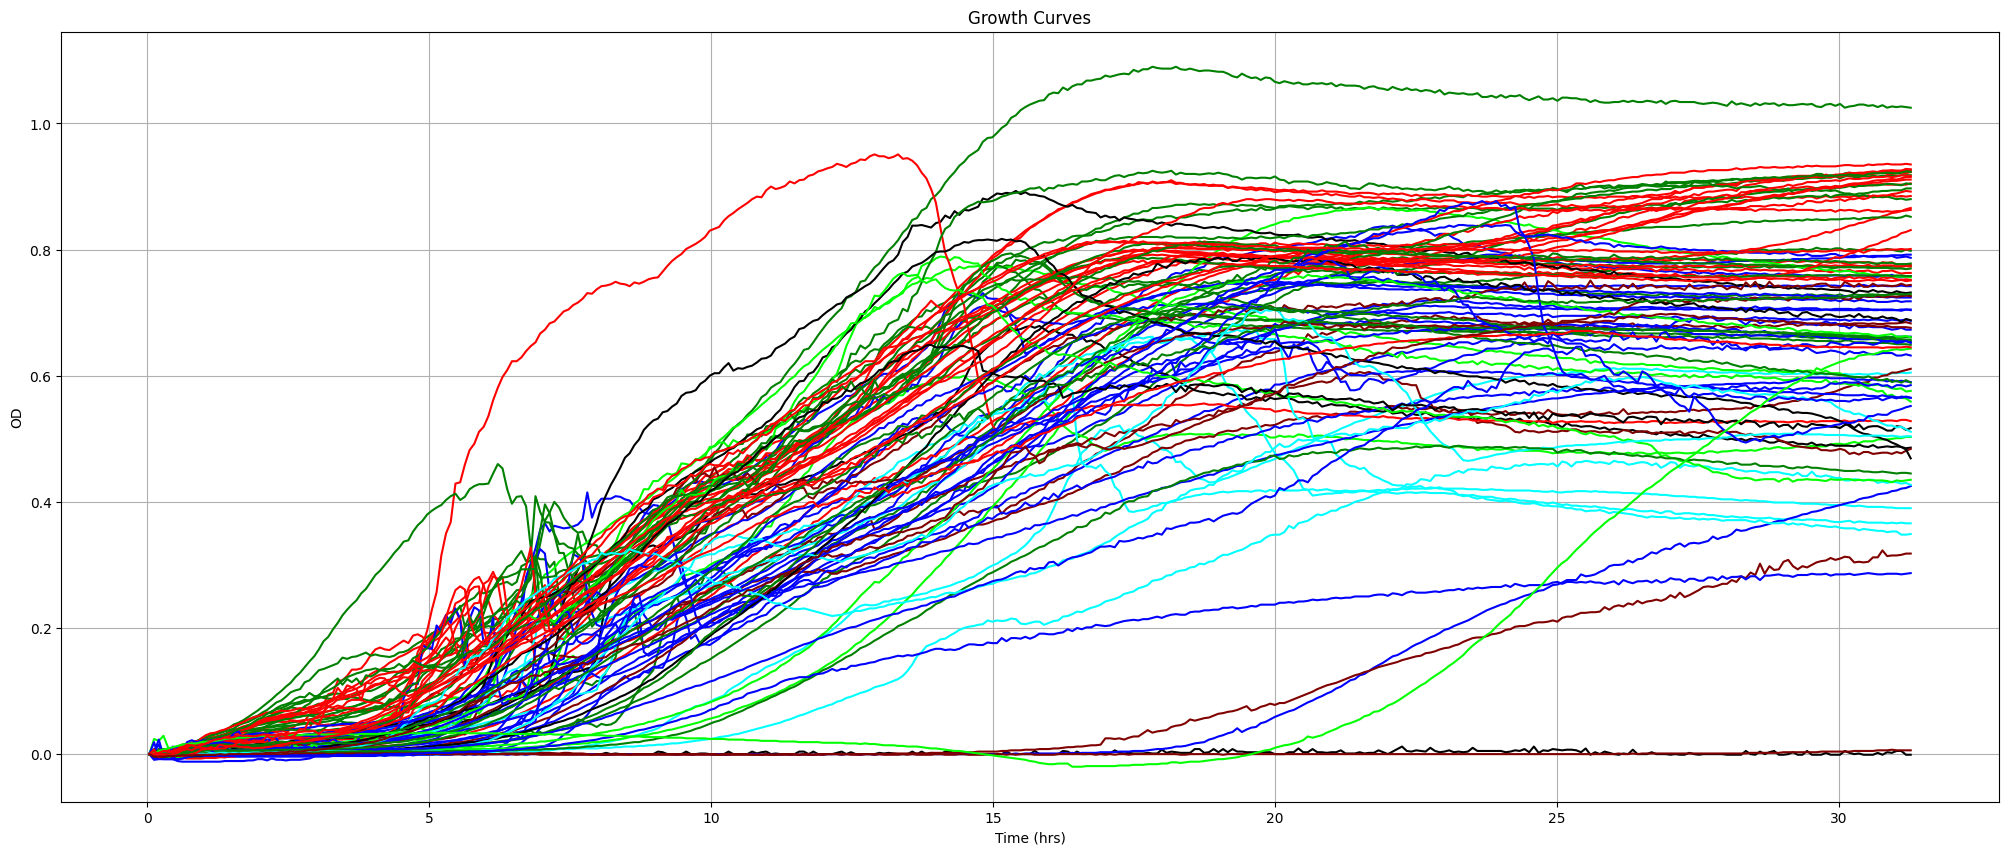

In [ ]:
#Defining a function to select the correct data: 
def data_select(meta_96_df):
  chosen_vials = meta_96_df.loc[(meta_96_df['Ecoli present']==1) & (meta_96_df['Dist_From_Edge'] >-1 )]# & (meta_96_df['Vial Phage']== 1)]# & (meta_96_df['Vial Osmolaity'] == 'medium')]#  & (meta_96_df['Dist_From_Edge'] >-1 ) & (meta_96_df['Vial Phage']== 0)]# & (meta_96_df['Vial Osmolaity'] == 'medium')]# & (meta_96_df['Wild type'] == 0) ]
  non_nan_vials = chosen_vials[chosen_vials['Well_Label'].notnull()]
  vial_list = non_nan_vials['Well_Label'].to_list()
  return vial_list

#Getting lists of well names of interest for each trial: 
vial_list = data_select(psg1_meta_df)

# Creating an array of colors:
color_rainbow=cm.rainbow(np.linspace(0,1,len(vial_list)))

# Plotting the OD vs time curves of each vial: 
plt.figure()
time1 = psg1_growth_df['Time'].to_list()
# time2 = psg2_growth_df['Time'].to_list()

# Making a dictionary to track replicates

# wt_v13_dict = {'B2':'grey', 'B3':'grey','D2':'blue','E3':'blue', 'F2':'cyan', 'G3':'cyan',
#                'B4':'navy','C5':'navy','D4':'green','E5':'green','F4':'lime','G5':'lime','B8':'greenyellow',
#                'C9':'greenyellow','D8':'red','E9':'red', 'F8':'maroon', 'G9':'maroon','B10':'lightsalmon',
#                'C11':'lightsalmon','D10':'black','E11':'black','F10':'orange','G11':'orange'}
# for i, vial in enumerate(vial_list):
#   c= wt_v13_dict.get(vial)
#   lbl = vial
#   plt.plot(time1, psg1_growth_df[vial].to_list(), label = lbl, color = c, alpha = 1)


## Coloring based on the original vial:
# vial_colors = ['grey','blue','cyan','navy','green','lime','greenyellow','red','maroon','lightsalmon','black','orange']
# for i, vial in enumerate(vial_list):
#   # c = vial_colors[int(vial[1:])-1]
#   c = color_rainbow[i]
#   print("Vial", vial, "Color", c)
#   lbl = f' vial {vial}'
#   a = 1
#   plt.plot(time1, psg1_growth_df[vial].to_list(), label = lbl, color = c, alpha = a)

plt.style.use('default')
plt.rcParams["figure.figsize"] = (25,10)

for i,vial in enumerate(vial_list):
  # plt.figure()
  if int(vial[1:]) <5:
    c = 'blue'
    # lbl = f'Phage + {vial}'
    lbl = 'low osm'
    a=1

  elif  4< int(vial[1:]) < 9:
    c= 'green'
    lbl = 'Phage + med osm'
    a=1
  elif 8< int(vial[1:])<12:
    c='red'
    lbl = f'Phage + mucoid {vial} high'
    a=1

  check = psg1_meta_df.loc[psg1_meta_df['Well_Label'] == str(vial)]['Vial Phage']
  if int(check) == 0: 
    lbl = 'Phage -'
    c = 'black'
    if int(vial[1:]) ==2:
      c = 'cyan'
    if int(vial[1:]) == 8:
      c= 'lime'
    if int(vial[1:]) == 12:
      c= 'maroon'
    a=1
  plt.plot(time1, psg1_growth_df[vial].to_list(), label = lbl, color = c, alpha = a)
  # plt.plot(time2, psg2_growth_df[vial].to_list(), label = lbl, color = c) 


plt.title("Growth Curves")
plt.xlabel('Time (hrs)')
plt.ylabel('OD')
# plt.plot(time1, psg1_growth_df[vial].to_list(), label = vial, color = color[i], alpha = 1)
# plt.xlim(8,25)
# plt.plot(time2, psg2_growth_df[vial].to_list(), label = vial, color = color[i])
# plt.draw()
# plt.legend()
plt.grid(True)
plt.show()
# plt.xlim(right = 30)


In [ ]:
print(psg1_meta_df.head(20))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


The average edge difference is nan
The headers are: ['+ phage low', '+ phage high', '+ phage medium', '- phage low', '- phage medium', 'Wt']


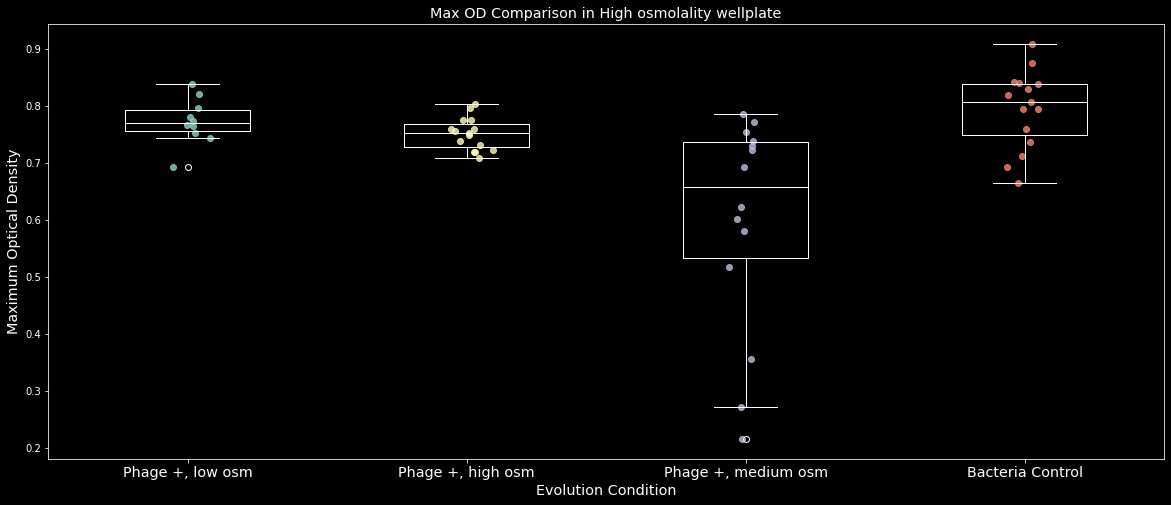

P-value for phage + high, phage + low =  0.12851857176511614
P value for phage + high, phage + med =  0.004358094200654259
P value for phage + low, phage + med=  0.008990743032141993
Anova test: f =  1.672382949848867 p=  0.22873144469959783


In [ ]:
# Making boxplot of 96 well data: 
def remove_na(df, col):
  vals = np.array([x for x in df[col].tolist() if np.isnan(x) == False])
  return vals

def create_df(df):
  feature = 'Smooth_Max_OD'
  osmo_list = ['low', 'high', 'medium']
  max_od_dict = {}
  qual_filt = df.loc[(df['Ecoli present'] ==1) & (df[feature] > .1 ) & (df['Dist_From_Edge'] >0)]
  vial_phage = qual_filt.loc[qual_filt['Vial Phage'] == 1]
  vial_non_phage = qual_filt.loc[(qual_filt['Vial Phage'] == 0) &(qual_filt['Wild type'] == 0)]
  vial_wt = qual_filt.loc[qual_filt['Wild type'] ==1]

  #Adding phage data in: 
  for osmo in osmo_list:
    max_od_dict['+ phage ' + str(osmo)] = vial_phage.loc[vial_phage['Vial Osmolaity'] == osmo][feature]
  for osmo in ['low', 'medium']: 
    max_od_dict['- phage ' + str(osmo)] = vial_non_phage.loc[vial_non_phage['Vial Osmolaity'] == osmo][feature]
  
  #Adding wt data in: 
  max_od_dict['Wt'] = vial_wt[feature]

  #Looking a columns instead: 
  # cols = [9,10,11]
  # for col in cols: 
  #   max_od_dict[f'+ phage c{col}'] = vial_phage.loc[(vial_phage['Vial Osmolaity'] == 'high') & (vial_phage['Column Number'] == col)][feature]

  # Doing an edge comparison
  edge_difference = []
  one_away_e_diff = []
  # Iterate through each column from chosen list
  cols = [2,3,4,5,6,7,8,9,10,11]
  for col in cols: 

    edge_vals = qual_filt.loc[(qual_filt['Dist_From_Edge'] == 0) & (qual_filt['Column Number'] == col) & (qual_filt['Wild type'] == 0)][feature]
    mid_vals = qual_filt.loc[(qual_filt['Dist_From_Edge'] > 0) & (qual_filt['Column Number'] == col) & (qual_filt['Wild type'] == 0)][feature]
    edge_diff = edge_vals - np.mean(mid_vals.dropna().to_list())
    edge_diff.dropna()
    edge_difference.extend(edge_diff.to_list())
    
    if col not in [2,11]:
      edge_vals2 = qual_filt.loc[(qual_filt['Dist_From_Edge'] == 1) & (qual_filt['Column Number'] == col) & (qual_filt['Wild type'] == 0)][feature]
      mid_vals2 = qual_filt.loc[(qual_filt['Dist_From_Edge'] > 1) & (qual_filt['Column Number'] == col) & (qual_filt['Wild type'] == 0)][feature]
      edge_diff2_na = edge_vals2 - np.mean(mid_vals2.dropna().to_list())
      edge_diff2 = edge_diff2_na.dropna()
      one_away_e_diff.extend(edge_diff2.to_list())
  

  # need to pad one_awaw list with nans to reach length of edge_difference: 
    while len(one_away_e_diff) < len(edge_difference):
      one_away_e_diff.append(np.nan)



  # e_dict = {'0 away edge diff':edge_difference,'1 away edge diff':one_away_e_diff}
  # print(e_dict)
  # e_df = pd.DataFrame.from_dict(e_dict)
  
  e_df = 1

  # grapher(e_df,'Edge Penalty OD', '')

  print("The average edge difference is", np.median(edge_difference))

  #Convetring to dataframe: 
  max_od_df = pd.DataFrame.from_dict(max_od_dict)
  return max_od_df,e_df


#Creating a dataframe that combines the data from each trial run: 
d1,e1 = create_df(psg1_meta_df)
combo_df = d1

# Saving this datafram: 
combo_df.to_csv("low_osm.csv")

# d2,e2 = create_df(psg2_meta_df)

# dframes = [d1, d2]
# combo_df = pd.concat(dframes)

# eframes = [e1,e2]
# e_combo = pd.concat(eframes)
# grapher(e_combo,'Edge Penalty OD', '')


#Creating a graph
grapher(combo_df, 'Maximum Optical Density', ' in High osmolality wellplate')

#Doing t-tests for high to low and medium osmolalites (should be sig): 
t1,p1 = stats.ttest_ind(remove_na(combo_df, '+ phage high'), remove_na(combo_df,'+ phage low'))
t2,p2 = stats.ttest_ind(remove_na(combo_df, '+ phage high'), remove_na(combo_df,'+ phage medium'))
t3, p3 = stats.ttest_ind(remove_na(combo_df, '+ phage medium'), remove_na(combo_df,'+ phage low'))
# Doing a one-way anova for non-phage conditions (should be ns)
f,p4 = stats.f_oneway(remove_na(combo_df, '- phage low'), remove_na(combo_df,'- phage medium'), remove_na(combo_df,'Wt'))

print("P-value for phage + high, phage + low = ", p1)
print("P value for phage + high, phage + med = ", p2)
print("P value for phage + low, phage + med= ", p3)
print("Anova test: f = ", f, "p= ", p4)



In [ ]:
# Doing line-plot comparisons of each isolate as the osmolality changes: 

# Downloading the high osmolality wellplate df: 
high_well_growth_df, high_well_meta_df = well96data('96_high_osmo_psg_3_growth.xlsx','96_well_psg3_meta.xlsx',42,45)

# Downloading the medium osmolality wellplate df: 
med_well_growth_df, med_well_meta_df = well96data('96_medium_osmo_psg_2_growth.xlsx','96_medium_osmo_psg2_meta.xlsx',20,35)

# Downloading the low osmolality wellplate df: 
low_well_growth_df, low_well_meta_df = well96data('96_low_osmo_psg_3_growth.xlsx','96_low_osmo_psg3_meta.xlsx',10,30)


Saving 96_high_osmo_psg_3_growth.xlsx to 96_high_osmo_psg_3_growth (3).xlsx


Saving 96_well_psg3_meta.xlsx to 96_well_psg3_meta.xlsx


Saving 96_medium_osmo_psg_2_growth.xlsx to 96_medium_osmo_psg_2_growth (1).xlsx


Saving 96_medium_osmo_psg2_meta.xlsx to 96_medium_osmo_psg2_meta (1).xlsx


Saving 96_low_osmo_psg_3_growth.xlsx to 96_low_osmo_psg_3_growth (3).xlsx


Saving 96_low_osmo_psg3_meta.xlsx to 96_low_osmo_psg3_meta (3).xlsx


In [ ]:
# Picking an experimental condition to analyze (phage high, phage medium, phage low) 
feature = 'Smooth_Max_OD'
vial_osmo = 'medium'
#Creating a dataframe that has max od's in high, medium, and low wells
well_comp_dict = {}
for df,name in zip([high_well_meta_df,med_well_meta_df,low_well_meta_df],['high','med','low']):
  well_comp_dict[name] = df.loc[(df['Vial Phage'] == 1) & (df['Ecoli present'] ==1) & (df['Vial Osmolaity']== vial_osmo) & (df['Dist_From_Edge'] >0)][feature].to_list()

well_comp_df = pd.DataFrame.from_dict(well_comp_dict)
print(well_comp_df.head())

# Also make a boxplot as well:
grapher(well_comp_df,'Smooth_Max_OD', 'Phage + High vial in different well osm')

# For each row, plot a line max od vs osmolality at a certain color
rainbow_color=cm.rainbow(np.linspace(0,1,len(well_comp_dict['high'])))
plt.figure()
for i in range(0,len(well_comp_dict['high'])):
  plt.plot(['high', 'med', 'low'], [well_comp_dict.get('high')[i], well_comp_dict.get('med')[i], well_comp_dict.get('low')[i]], color = rainbow_color[i])

plt.show()



NameError: ignored

In [ ]:
# Loading the metadata fitting excel file from computer:
uploaded1 = files.upload()


Saving plate_reader_t2_for_matlab_fits.xlsx to plate_reader_t2_for_matlab_fits.xlsx


In [ ]:
#Loading the raw OD data from the computer" 
uploaded2 = files.upload()
growth_df = pd.read_excel(io.BytesIO(uploaded2['plate_reader_t2_for_matlab.xlsx']),skiprows=6)

#Adjusting the time column to contain hours (right now a value of 1 = 24 hours. )
growth_df['Time'] = growth_df['Time'] * 24
print(growth_df.head())


Saving plate_reader_t2_for_matlab.xlsx to plate_reader_t2_for_matlab.xlsx
       Time     A1     A2     A3     A4     A5     A6  ...    P11    P13  \
0  0.033889  0.085  0.083  0.084  0.083  0.083  0.086  ...  0.082  0.082   
1  0.153611  0.085  0.083  0.084  0.083  0.083  0.086  ...  0.082  0.082   
2  0.273333  0.086  0.083  0.084  0.083  0.083  0.086  ...  0.082  0.083   
3  0.393056  0.087  0.083  0.084  0.083  0.083  0.086  ...  0.082  0.083   
4  0.512778  0.088  0.083  0.084  0.083  0.084  0.086  ...  0.083  0.083   

     P15    P17    P19    P21    P23  
0  0.082  0.083  0.082  0.081  0.086  
1  0.082  0.083  0.082  0.081  0.086  
2  0.082  0.083  0.082  0.081  0.086  
3  0.082  0.083  0.083  0.081  0.086  
4  0.082  0.083  0.083  0.081  0.086  

[5 rows x 289 columns]


In [ ]:
#Creating the metadata df: 
meta_df = pd.read_excel(io.BytesIO(uploaded1['plate_reader_t2_for_matlab_fits.xlsx']))

#Making some adjustments to the metadata file: 

#Labelling the metadata with the actual vial location in another column:
well_names = []
letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P']
for i,letter in enumerate(letters):
  for n in range(1,25):
    if i%2 == 0:
      well_names.append(letter + str(n))
    else:
      if n%2 != 0:
        well_names.append(letter + str(n))

meta_df.insert(11, "Well_Label", well_names)

#Adding a new maximum value column baesd of the max of a medfilt on the dataframe

smooth_max_od = []
for i, name in enumerate(well_names):
  # Getting the initial od to subtract as a baseline value: 
  init_od = growth_df[name].iloc[0]

  # Getting the max od ans subtracting the initial od from this
  # Only look at first 40 hours.   
  max_od = np.max(medfilt(growth_df.loc[growth_df['Time'] < 40][name],3)) - init_od

  smooth_max_od.append(max_od)

  growth_df[name] = growth_df[name] - init_od

meta_df.insert(12,"Smooth_Max_OD",smooth_max_od)


In [ ]:
#Plotting individual wells OD vs Time

# If you would like to plot a single vial: 
# growth_df.plot('Time', 'A5')
# growth_df.plot('Time', 'B5')

plt.style.use('default')
plt.rcParams["figure.figsize"] = (25,10)


def non_nan(chosen_vials):
  non_nan_vials = chosen_vials[chosen_vials['Well_Label'].notnull()]
  non_nan_vials = non_nan_vials['Well_Label'].to_list()
  return non_nan_vials

# Choices for well_omsolality are : 230, 457, 945
# chosen_vials = meta_df.loc[(meta_df['Well_Osmolality'] == 945) & (meta_df['Vial_Phage'] == 1)]
well_osmo = 457
chosen_vials1 = meta_df.loc[(meta_df['Wild_type'] ==0) & (meta_df['Well_Osmolality']== well_osmo) & (meta_df['Vial_Phage'] ==1) &(meta_df['Vial_Osmolaity'] == 230)]# & (meta_df['Well_Osmolality']== 230) &(meta_df['Vial_Osmolaity'] == 230)]
non_nan_vials1 = non_nan(chosen_vials1)

chosen_vials2 = meta_df.loc[(meta_df['Wild_type'] ==0) & (meta_df['Well_Osmolality']== well_osmo) & (meta_df['Vial_Phage'] ==1) &(meta_df['Vial_Osmolaity'] == 457)]# & (meta_df['Well_Osmolality']== 230) &(meta_df['Vial_Osmolaity'] == 230)]
non_nan_vials2 = non_nan(chosen_vials2)

chosen_vials3 = meta_df.loc[(meta_df['Wild_type'] ==0) & (meta_df['Well_Osmolality']== well_osmo) & (meta_df['Vial_Phage'] ==1) &(meta_df['Vial_Osmolaity'] == 945)]# & (meta_df['Well_Osmolality']== 230) &(meta_df['Vial_Osmolaity'] == 230)]
non_nan_vials3= non_nan(chosen_vials3)

chosen_vials4 = meta_df.loc[(meta_df['Wild_type'] ==0) & (meta_df['Well_Osmolality']== well_osmo) & (meta_df['Vial_Phage'] ==0)]# & (meta_df['Well_Osmolality']== 230) &(meta_df['Vial_Osmolaity'] == 230)]
non_nan_vials4= non_nan(chosen_vials4)

plt.figure()
time = growth_df['Time'].to_list()
for i,vial in enumerate(non_nan_vials1):
    c = 'blue'
    lbl = 'low osm evo'
    plt.plot(time, growth_df[vial].to_list(), label = lbl, color = c)

for i,vial in enumerate(non_nan_vials2):
    c = 'green'
    lbl = 'med_osm_evo'
    plt.plot(time, growth_df[vial].to_list(), label = lbl, color = c)

for i,vial in enumerate(non_nan_vials3):
    c = 'red'
    lbl = 'high_osm_evo'
    plt.plot(time, growth_df[vial].to_list(), label = lbl, color = c)

for i,vial in enumerate(non_nan_vials4):
    c = 'black'
    lbl = 'WT'
    plt.plot(time, growth_df[vial].to_list(), label = lbl, color = c)


# plt.legend()
plt.title(f'Cell Growth in {well_osmo} Osmolality wells')
plt.ylabel('OD')
plt.xlabel('Time (hours)')
# plt.title("WT medium osmolality first experiment with smaller air holes")
plt.yticks(np.arange(0, .9, .1))
plt.xticks(np.arange(0, 80, 1))
plt.grid(True)
plt.xlim(right = 80)
plt.show()

NameError: ignored

In [ ]:
# Picking subset choices for analysis: 
feature = 'Smooth_Max_OD' # can also be 'rate' or 'Smooth_Max_OD'

# A list of osmolalites:
osmo_list = [230,457,945]

# Quality Filtering: 
qual_df = meta_df.loc[(meta_df['Smooth_Max_OD'] > -.11) & (meta_df['rate'] > -0.01) & (meta_df['flag'] == 0)]

#Looking at the Phage + data: 
all_phage = qual_df.loc[qual_df['Vial_Phage']== 1]

#Looking at phage - data: 
phage_minus = qual_df.loc[qual_df['Vial_Phage'] == 0]

# Looking at the WT data: 
all_wt_data = qual_df.loc[(qual_df['Wild_type'] == 1)]



#Adding phage + and phage - data: 
max_od_dict = {}
for well_os in osmo_list:
  for vial_os in osmo_list:
    name = str("V" + str(vial_os) + " W" + str(well_os) + " +")
    max_od_dict[name] =all_phage.loc[(all_phage['Well_Osmolality']== well_os) & (all_phage['Vial_Osmolaity'] == vial_os)][feature]

# # Adding the WT data: 
# for well_os in osmo_list: 
#   name = str("WT " + str(well_os))
#   max_od_dict[name] = all_wt_data.loc[all_wt_data['Well_Osmolality'] == well_os][feature] 

# #Adding Phage - data: 
# for well_os in osmo_list:
#   for vial_os in osmo_list:
#     name = str("V" + str(vial_os) + " W" + str(well_os) + " -")
#     max_od_dict[name] =phage_minus.loc[(phage_minus['Well_Osmolality']== well_os) & (phage_minus['Vial_Osmolaity'] == vial_os)][feature]

  

#Turning the dictionary into a dataframe for the boxplotting: 
feature_bxplt = pd.DataFrame.from_dict(max_od_dict)
#Creating a graph
grapher(feature_bxplt, feature,"")




NameError: ignored